In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def smoothing(list_, n_smooth=250):
    smoothed_list_ = []
    for i in range(len(list_)):
        if i < n_smooth:
            smoothed_list_.append(np.mean(list_[:i+1]))
        else:
            smoothed_list_.append(np.mean(list_[i-n_smooth:i+1]))
    return smoothed_list_            


def plot_graph(x_values, y_values, color_, title_):
    plt.plot(x_values, y_values, c=color_)
    plt.title(title_)
    plt.grid(True)

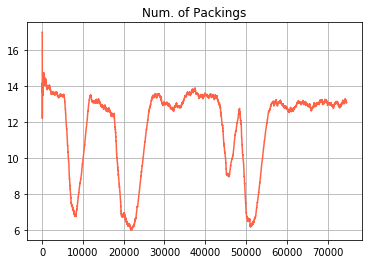

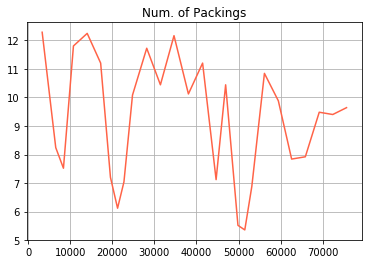

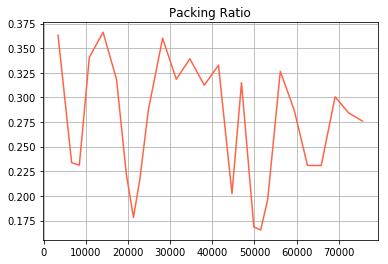

In [3]:
result_dir = "./results/board/"
model_list = ["FCDQN_1120_1313"]
color_list = ["tomato", "orange"]

plt.figure(figsize=(6,4))


for model_idx, model_name in enumerate(model_list):
    result_file = result_dir + model_name + ".npy"
    result_ = np.load(result_file, allow_pickle=True)
    
    testlens_ = result_[2]
    testlens_ = smoothing(testlens_)
    
    eplens_ = result_[2]
    cumlens_ = np.cumsum(eplens_)
    
    plot_graph(cumlens_, testlens_, color_list[model_idx], "Num. of Packings")

    
plt.show()

for model_idx, model_name in enumerate(model_list):
    result_file = result_dir + model_name + ".npy"
    result_ = np.load(result_file, allow_pickle=True)
    
    testlens_ = result_[3]
    eplens_ = result_[5]
    
    plot_graph(eplens_, testlens_, color_list[model_idx], "Num. of Packings")

    
plt.show()

for model_idx, model_name in enumerate(model_list):
    result_file = result_dir + model_name + ".npy"
    result_ = np.load(result_file, allow_pickle=True)
    
    testlens_ = result_[4]
    eplens_ = result_[5]
    
    plot_graph(eplens_, testlens_, color_list[model_idx], "Packing Ratio")

    
plt.show()

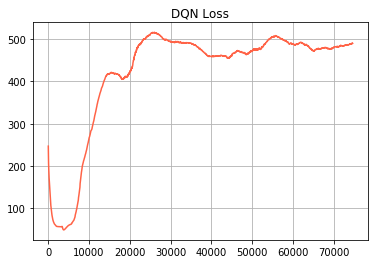

In [5]:
plt.figure(figsize=(6,4))

for model_idx, model_name in enumerate(model_list):
    result_file = result_dir + model_name + ".npy"
    result_ = np.load(result_file, allow_pickle=True)

    rewards_ = result_[0]
    losses_ = result_[1]

    eplens_ = result_[2]
    cumlens_ = np.cumsum(eplens_)

    n_data = len(rewards_)
    
    smoothed_losses_ = smoothing(losses_)
    plot_graph(cumlens_, smoothed_losses_, color_list[model_idx], "DQN Loss")

    
plt.show()